Monte Carlo simulation and some tests

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats as sps

In [2]:
from SABR_montecarlo import *
from SABR_onestep import *
from SABR_approx import *

In [3]:
from BlackScholes import BlackScholes, ImpliedVolatility

In [4]:
def GetIVMonte(K, F0, tn, r, Npaths, simulator, sig0, alpha, beta, rho):
    
    T = tn[-1]
    
    F = simulator(F0, sig0, Npaths, tn, alpha, beta, rho)
    
    #moment matching
    F = F - np.mean(F) + F0
    payoff = np.maximum(F.reshape(-1, 1) - K.reshape(1, -1), 0.0)
    
    C = np.mean(payoff, axis=0)
    IV = ImpliedVolatility(C, K, F0, T, r)
    return C, IV

In [5]:
Npaths = 1000000
Nt = 10

F0 = 5
sig0 = 0.2

alpha= 0.3
beta = 0.4
rho = 0.3

r = 0.0

T = 3
tn = T * np.linspace(0, 1, Nt + 1)

In [6]:
F_bess_1 = SabrBessel(F0, sig0, Npaths, tn, alpha, beta, rho)
F_euler = SabrEuler(F0, sig0, Npaths, tn, alpha, beta, rho)
F_euler_mod = SabrEulerModified(F0, sig0, Npaths, tn, alpha, beta, rho)
F_direct = SabrDirectInversionScheme(F0, sig0, Npaths, [0, T/2, T], alpha, beta, rho)

In [7]:
Fs = [F_bess_1, F_euler, F_euler_mod, F_direct]
names = ["besel1", "euler", "eulerm", "direct"]

for name, F in zip(names, Fs):
    q75 = np.quantile(F, 0.75)
    pzero = np.mean(F == 0.0) * 100
    print(f'{name},\t mean = {np.mean(F):4f} \t max = {np.max(F):4f}, \t q75 = {q75:4f}, \t p_0 = {pzero:4f}%')
    

besel1,	 mean = 4.999326 	 max = 15.863666, 	 q75 = 5.389763, 	 p_0 = 0.000000%
euler,	 mean = 5.001008 	 max = 14.079865, 	 q75 = 5.393343, 	 p_0 = 0.000000%
eulerm,	 mean = 5.000622 	 max = 16.716318, 	 q75 = 5.390513, 	 p_0 = 0.000000%
direct,	 mean = 5.039239 	 max = 15.777399, 	 q75 = 5.421915, 	 p_0 = 0.000000%


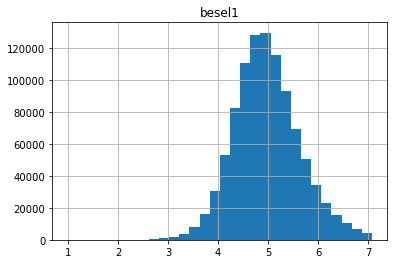

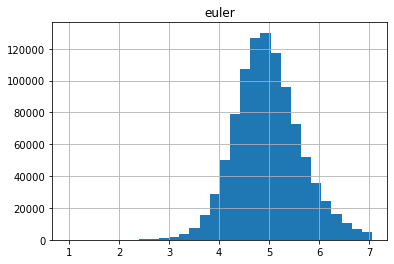

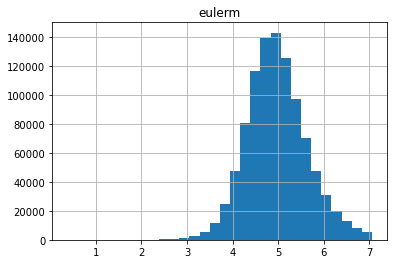

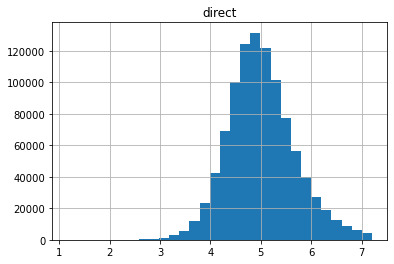

In [8]:
for name, F in zip(names, Fs):
    plt.figure()
    q = np.quantile(F, 0.99)
    plt.hist(F[F < q], bins=30)
    plt.grid()
    plt.title(name)
None

In [9]:
K = np.linspace(0.1 * F0, 2.0 * F0, 51)

In [10]:
Cpetr, ivpetr = SabrApprox(K, F0, r, T, sig0, alpha, beta, rho)

In [11]:
ivs = {}
Cs = {}
for name, F in zip(names, Fs):
    F_ = (F - np.mean(F)) + F0
    payoff = np.maximum(F_.reshape(-1, 1) - K.reshape(1, -1), 0.0)
    Cs[name] = np.mean(payoff, axis=0)
    ivs[name] = ImpliedVolatility(Cs[name], K, F0, T, r)

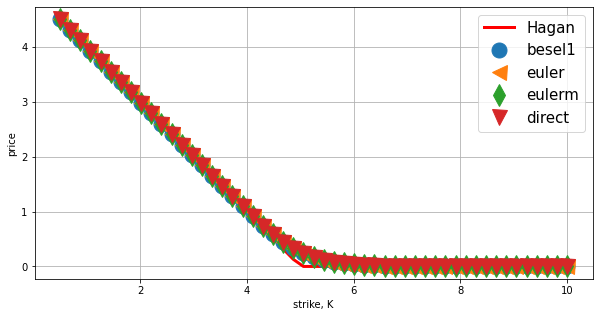

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(K, Cpetr, '-r', linewidth=3.0, label='Hagan')
markers = ['o', '<', 'd', 'v']
i = 0
for name, C in Cs.items():
    plt.plot(K, C, markers[i], markersize=15, label=name)
    i += 1
plt.legend(fontsize=15)
plt.xlabel("strike, K")
plt.ylabel("price")
plt.grid()
None

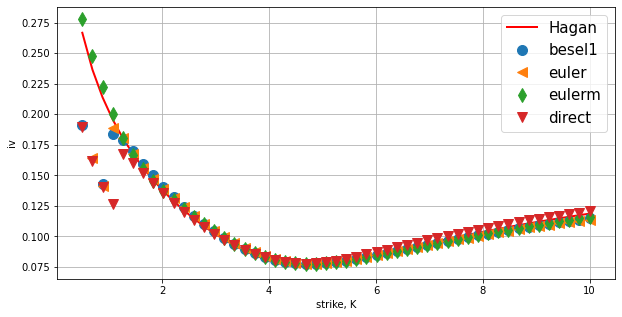

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(K, ivpetr, '-r', linewidth=2.0, label='Hagan')
markers = ['o', '<', 'd', 'v']
i = 0
for name, iv in ivs.items():
    plt.plot(K, iv, markers[i], markersize=10, label=name)
    i += 1
plt.legend(fontsize=15)
plt.xlabel("strike, K")
plt.ylabel("iv")
plt.grid()
None

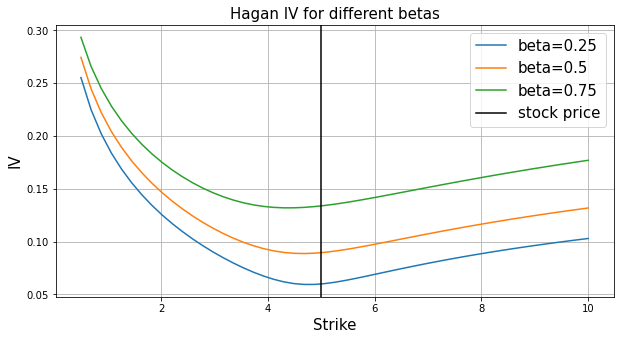

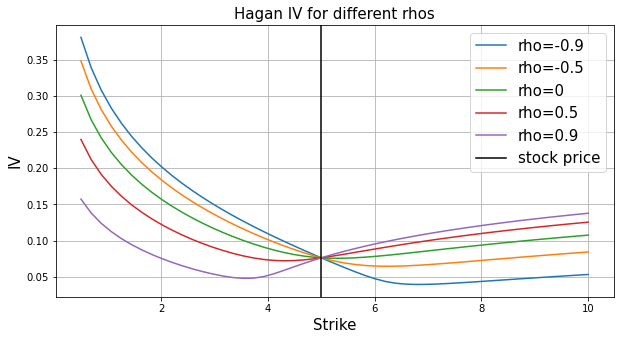

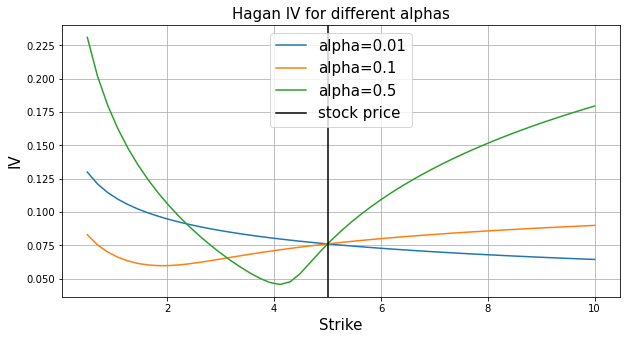

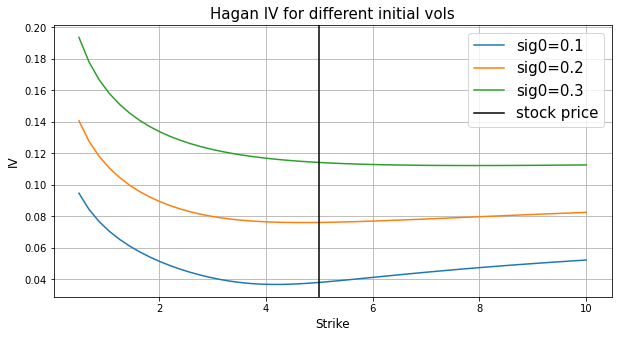

In [14]:
betas = 0.25, 0.5, 0.75

plt.figure(figsize=(10, 5))
for beta in betas:
    C, iv = SabrApprox(K, F0, r, T, sig0, alpha, beta, rho)
    
    plt.plot(K, iv, label=f"beta={beta}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("IV", fontsize=15)
plt.title("Hagan IV for different betas", fontsize=15)
None


beta = 0.4

rhos = [-0.9, -0.5, 0, 0.5, 0.9]

plt.figure(figsize=(10, 5))
for rho in rhos:
    C, iv = SabrApprox(K, F0, r, T, sig0, alpha, beta, rho)
    plt.plot(K, iv, label=f"rho={rho}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("IV", fontsize=15)
plt.title("Hagan IV for different rhos", fontsize=15)
None


beta = 0.4

alphas = [0.01, 0.1, 0.5]

plt.figure(figsize=(10, 5))
for alpha in alphas:
    C, iv = SabrApprox(K, F0, r, T, sig0, alpha, beta, rho)
    plt.plot(K, iv, label=f"alpha={alpha}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("IV", fontsize=15)
plt.title("Hagan IV for different alphas", fontsize=15)
None


beta = 0.4
alpha = 0.1
rho = 0.5

sig0s = [0.1, 0.2, 0.3]

plt.figure(figsize=(10, 5))
for si in sig0s:
    C, iv = SabrApprox(K, F0, r, T, si, alpha, beta, rho)
    plt.plot(K, iv, label=f"sig0={si}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=12)
plt.ylabel("IV", fontsize=12)
plt.title("Hagan IV for different initial vols", fontsize=15)
None

In [18]:
Npath = 1000000

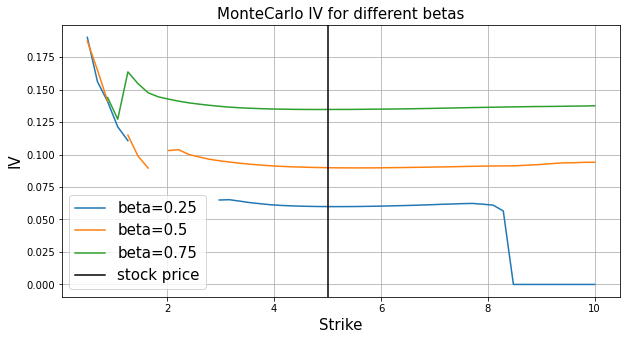

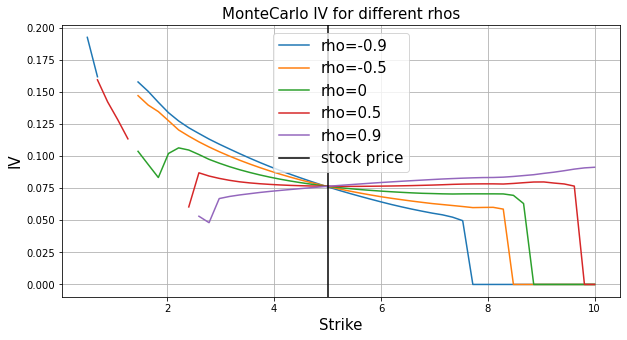

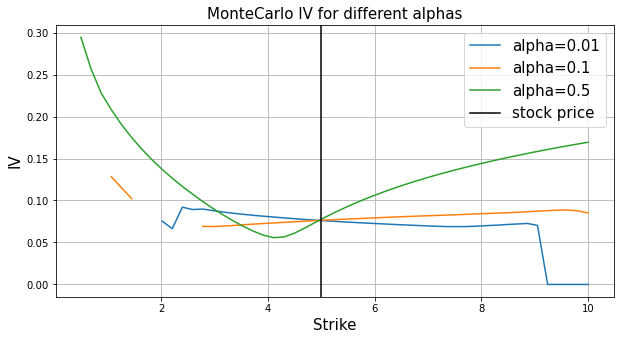

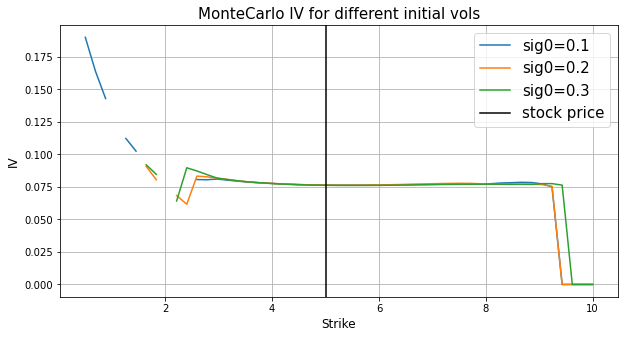

In [19]:
title = "MonteCarlo IV for different"

betas = 0.25, 0.5, 0.75

plt.figure(figsize=(10, 5))
for beta in betas:
    C, iv = GetIVMonte(K, F0, tn, r, Npath, SabrEuler, sig0, alpha, beta, rho)
    
    plt.plot(K, iv, label=f"beta={beta}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("IV", fontsize=15)
plt.title(title + " betas", fontsize=15)
None


beta = 0.4

rhos = [-0.9, -0.5, 0, 0.5, 0.9]

plt.figure(figsize=(10, 5))
for rho in rhos:
    C, iv = GetIVMonte(K, F0, tn, r, Npath, SabrEuler, sig0, alpha, beta, rho)
    plt.plot(K, iv, label=f"rho={rho}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("IV", fontsize=15)
plt.title(title + " rhos", fontsize=15)
None


beta = 0.4

alphas = [0.01, 0.1, 0.5]

plt.figure(figsize=(10, 5))
for alpha in alphas:
    C, iv = GetIVMonte(K, F0, tn, r, Npath, SabrEuler, sig0, alpha, beta, rho)
    plt.plot(K, iv, label=f"alpha={alpha}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=15)
plt.ylabel("IV", fontsize=15)
plt.title(title + " alphas", fontsize=15)
None


beta = 0.4
alpha = 0.1
rho = 0.5

sig0s = [0.1, 0.2, 0.3]

plt.figure(figsize=(10, 5))
for si in sig0s:
    C, iv = GetIVMonte(K, F0, tn, r, Npath, SabrEuler, sig0, alpha, beta, rho)
    plt.plot(K, iv, label=f"sig0={si}")
plt.axvline(x=F0, c='k', label='stock price')
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Strike", fontsize=12)
plt.ylabel("IV", fontsize=12)
plt.title(title + " initial vols", fontsize=15)
None